<a href="https://colab.research.google.com/github/GuptaNavdeep1983/DeepLearningRepo/blob/main/TensorFlow4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.3.0


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [3]:
# Importing pathlib to import necessary set of images
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [4]:
# Print the image count
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [5]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'tulips', 'roses', 'dandelion', 'sunflowers'],
      dtype='<U10')

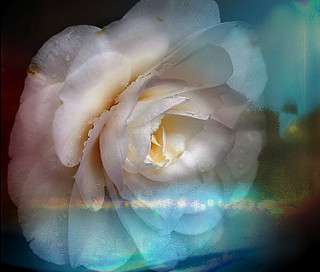

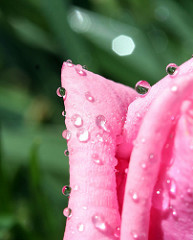

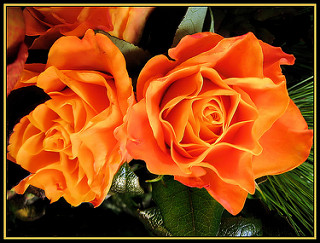

In [6]:
# Here, Image.open() method Opens and identifies the given image file.
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Load using `keras.preprocessing`

In [7]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # TODO 1a

In [9]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
STEPS_PER_EPOCH

115.0

In [10]:
# Generate batches of tensor image data with real-time data augmentation.
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [11]:
# Here, define show_batch() procedure for Inspecting a batch.
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1) # TODO 1b
      plt.imshow(image_batch[n]) # TODO 1b
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

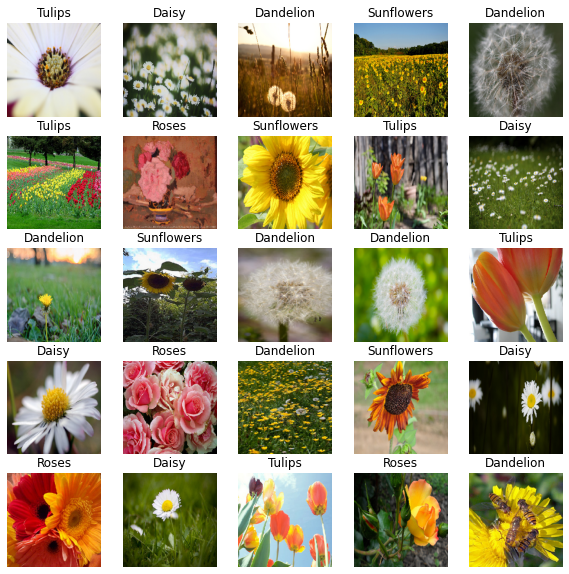

In [12]:
# Here, next() function returns the next item in an iterator.
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)


## Load using `tf.data`

The above `keras.preprocessing` method is convienient, but has three downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

In [13]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [14]:
# Here, .take() method return elements from array along the mentioned axis and indices.
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/16737503507_431768a927.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/9610098411_f1613c8e14.jpg'
b'/root/.keras/datasets/flower_photos/daisy/1299501272_59d9da5510_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/14487705209_ea723109e1_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4933230395_7930697335_m.jpg'


In [16]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep) # TODO 2a
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES # TODO 2a

In [17]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3) # TODO 2b
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32) # TODO 2b
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [18]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path) # TODO 2c
  img = decode_img(img)
  return img, label

In [19]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [20]:
# Print the value of `Image shape` and `Label`
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False False False False]
